# ML Method for Recommendations

In [ ]:
!pip3 install surpise

In [ ]:
!pip3 install plotly

In [11]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate
import pandas as pd
import numpy as np
import io
import os
import matplotlib.pyplot as plt
from surprise.model_selection import KFold, GridSearchCV

In [12]:
user_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=user_cols,
                    encoding='latin-1', parse_dates=True) 

ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols,
                      encoding='latin-1')

movies_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, usecols=range(5),
                     encoding='latin-1')

movie_ratings = pd.merge(movies, ratings)
df = pd.merge(movie_ratings, users)

df.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076


In [13]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [15]:
movies.to_csv('movies.csv')

In [16]:
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            100000 non-null  int64  
 1   title               100000 non-null  object 
 2   release_date        99991 non-null   object 
 3   video_release_date  0 non-null       float64
 4   imdb_url            99987 non-null   object 
 5   user_id             100000 non-null  int64  
 6   rating              100000 non-null  int64  
 7   timestamp           100000 non-null  int64  
 8   age                 100000 non-null  int64  
 9   sex                 100000 non-null  object 
 10  occupation          100000 non-null  object 
 11  zip_code            100000 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 9.9+ MB


In [18]:
#Data Pre-Processing

df.drop(df.columns[[3,4,7]], axis=1, inplace=True)
ratings.drop("timestamp", inplace = True, axis = 1 ) 
movies.drop(movies.columns[[3,4]], inplace = True, axis = 1 )
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   movie_id      100000 non-null  int64 
 1   title         100000 non-null  object
 2   release_date  99991 non-null   object
 3   user_id       100000 non-null  int64 
 4   rating        100000 non-null  int64 
 5   age           100000 non-null  int64 
 6   sex           100000 non-null  object
 7   occupation    100000 non-null  object
 8   zip_code      100000 non-null  object
dtypes: int64(4), object(5)
memory usage: 7.6+ MB


# Exploratory Data Analysis

## Ratings Distribution By Movie

In [19]:
import plotly
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

data = df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} movie ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [20]:
df.groupby('title')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,title,rating
1398,Star Wars (1977),583
333,Contact (1997),509
498,Fargo (1996),508
1234,Return of the Jedi (1983),507
860,Liar Liar (1997),485
460,"English Patient, The (1996)",481
1284,Scream (1996),478
1523,Toy Story (1995),452
32,Air Force One (1997),431
744,Independence Day (ID4) (1996),429


## Ratings Distribution By User

In [21]:
# Number of ratings per user
data = df.groupby('user_id')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [22]:
df.groupby('user_id')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,user_id,rating
404,405,737
654,655,685
12,13,636
449,450,540
275,276,518
415,416,493
536,537,490
302,303,484
233,234,480
392,393,448


## Ratings Distribution By Age

In [31]:
# Number of ratings per user
data = df.groupby('age')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Age (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per Age'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

## Users Distribution By Age

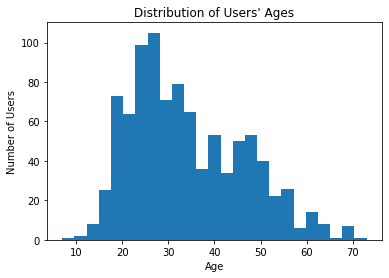

In [24]:
users.age.plot.hist(bins=25)
plt.title("Distribution of Users' Ages")
plt.ylabel('Number of Users')
plt.xlabel('Age');

# Recommendation Engine

## Machine Learning

In [25]:
reader = Reader(rating_scale = (0.5,4.))
data = Dataset.load_from_df(ratings, reader)

# cross-validation iterator
kf = KFold(n_splits=5)
model = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    model.fit(trainset)
    predictions = model.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.9507
RMSE: 0.9501
RMSE: 0.9484
RMSE: 0.9423
RMSE: 0.9453


### Making Recommendations

In [26]:
# map movie to id:
Mapping_file = dict(zip(movies.title.tolist(), movies.movie_id.tolist()))

def pred_user_rating(ui):
    if ui in ratings.user_id.unique():
        ui_list = ratings[ratings.user_id == ui].movie_id.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = model.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        ui_list = ratings[ratings.user_id == ui].movie_id.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = model.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)    

In [40]:
#Given an existing user ID return a list of recommended movies
user_id = 201
pred_user_rating(user_id)

,ratings
movies,
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963),3.736300
12 Angry Men (1957),3.694307
"Wrong Trousers, The (1993)",3.683193
To Kill a Mockingbird (1962),3.624025
"African Queen, The (1951)",3.607720
Much Ado About Nothing (1993),3.595895
Strictly Ballroom (1992),3.559583
Mr. Smith Goes to Washington (1939),3.552978
Arsenic and Old Lace (1944),3.546912


In [45]:
#Given a new user return a list of recommended movies
user_id = 7029
pred_user_rating(user_id)

,ratings
movies,
One Flew Over the Cuckoo's Nest (1975),4.0
It's a Wonderful Life (1946),4.0
Blade Runner (1982),4.0
Rear Window (1954),4.0
Henry V (1989),4.0
Much Ado About Nothing (1993),4.0
Amadeus (1984),4.0
Raging Bull (1980),4.0
"Fugitive, The (1993)",4.0


## Tuning and Evaluating the Model 

In [29]:
param_grid = {'lr_all' : [.001, .01], 'reg_all': [.1, .5]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
grid_search.fit(data)
print(grid_search.best_params['rmse'])

{'lr_all': 0.01, 'reg_all': 0.1}


In [30]:
model = SVD(lr_all = .001)
output = cross_validate(model, data, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9757  0.9786  0.9740  0.9664  0.9745  0.9738  0.0041  
MAE (testset)     0.7743  0.7760  0.7714  0.7646  0.7713  0.7715  0.0039  
Fit time          4.08    4.31    5.54    5.45    5.60    5.00    0.66    
Test time         0.16    0.10    0.26    0.13    0.20    0.17    0.05    


#### As you can see, the model can give recommended movies based on what it believes the user would rate the movie. You can also create a new user and the recommended movies will be the most common movies.